In [10]:
import numpy as np
import pandas as pd
import networkx as nx
import string
import math
import re
import sys
import spacy
import gensim
import matplotlib.pyplot as plt
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sindhuhegde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sindhuhegde/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
import numpy as np, pandas as pd
from scipy import sparse

import string, re, emoji, regex, spacy, nltk, gensim  
from nltk.corpus import stopwords
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.parsing.preprocessing import STOPWORDS as SW
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import MiniBatchKMeans

import matplotlib.pyplot as plt, matplotlib.colors as mcolors, seaborn as sns, plotly.express as px, pyLDAvis
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
import pyLDAvis.gensim_models as gensimvis

import sys, logging, warnings, pickle
from collections import Counter
warnings.simplefilter("ignore")

# Pre-processing

In [12]:
df = pd.read_csv("ietf_data.csv")

In [13]:
df = df[df.columns[df.columns.isin(['_id', 'body', 'gridfs_id','headers.Date','headers.From', 'headers.In-Reply-To', 'headers.Message-ID', 'headers.Subject', 'imap_uid', 'list', 'size', 'timestamp' ])]]

In [14]:
#df

In [15]:
df = df.dropna(subset=["list"])
df = df.dropna(subset=["headers.Date"])
df = df.dropna(subset = ["headers.Subject"])

In [16]:
"""
Drop the rows which are having Nan values in the headers.From and body column.
"""

df = df.dropna(subset=["headers.From","body"])


"""
Delete the first paragraph from the body that contains From, message-ID, Date and some other informations.
"""
s = []
for i in range(len(df)):
    s.append(df.iloc[i]["body"].split("\n\n",1)[0])

df["body"] = s


In [17]:
"""
get the stopwords list and the lemmetizers
"""
stopwords_list = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
"""
Define a function to process the data which does the following operations:
1.removes the punctualtions, stop
2. Stopword removal
3.lemmatization
"""
def process_text(data):

    #Removed punctuation
    if data:
        data = ''.join([char for char in data if char not in string.punctuation]) 
    #removed stopwords
        data = ' '.join([word.lower() for word in data.split() if word.lower() not in stopwords_list]) 
    #lemmatization
        data = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in data.split()]) 
    return data

In [19]:
"""
Processing the headers.From column - get the name of the author and the company
"""

email_addr = []
for i in range(len(df)):
    s = df["headers.From"].iloc[i]
#     print(s)
    s = s.strip('\"')
    if type(s) == str:
        if len(s) == 0:
            print(i, df["headers.From"].iloc[i])
            email_addr.append(["", ""])
        if len(s) != 0:
            lst = re.search(r'([\w\.-]+)@([\w\.-]+)', s)
            if not lst:
                lst = re.search(r'(\S+) at (\S+)', s)
            if lst:
                email_addr.append([lst.group(1), lst.group(2)])    

In [20]:
"""
Get the list of unique authors
"""
name = []
affiliation = []
for i in range(len(email_addr)):
    if email_addr[i][0]:
        name.append(email_addr[i][0].lower())
        affiliation.append(email_addr[i][1])
name_df = pd.DataFrame({'authors':name})
aff_df = pd.DataFrame({'affiliation':affiliation})
unique_name = name_df['authors'].unique()

In [21]:
df['name'] = name_df['authors']
df['affiliation'] = aff_df['affiliation']
#df.head(100)

In [22]:
df['affiliation'].value_counts().head(5)

gmail.com       9671
mnot.net        4041
gmx.de          3075
ericsson.com    2398
cisco.com       2056
Name: affiliation, dtype: int64

In [23]:
len(unique_name)

1700

In [24]:
from collections import defaultdict
d = defaultdict(lambda: len(d))
unique_id = [d[x] for x in df['name']]
len(unique_id)

57966

In [25]:
"""
Pre-processing of headers.subject by removing non-important information
"""

subject = []
indexs = []

for i in tqdm(range(len(df))):
    try:
        mystring = str(df["headers.Subject"].iloc[i])
        if not mystring:
            continue
        start = mystring.rfind("[")
        end = mystring[start:].find("]")
        while start != -1 and end != -1:
            mystring = mystring[:start] + mystring[start+end+1:]
            start = mystring.rfind("[")
            end = mystring[start:].find("]")
        if len(mystring) == 0:
    #         print(i, df["headers.Subject"].iloc[i],"\n", mystring)
            indexs.append(df.iloc[[i]].index[0])
        else:
            mystring = mystring.replace("Re:", "").strip()
            if len(mystring) == 0:
                indexs.append(df.iloc[[i]].index[0])
            else:
                subject.append(mystring)
    except:
        print(mystring)
        break
# df = df.drop(index=indexs)
# df["headers.Subject"] = subject
# len(df)

100%|██████████| 57966/57966 [00:00<00:00, 136547.10it/s]


In [26]:
len(df["headers.Subject"].unique())


15999

# Examine the pattern of connections generated over time 

  0%|          | 0/4 [00:00<?, ?it/s]

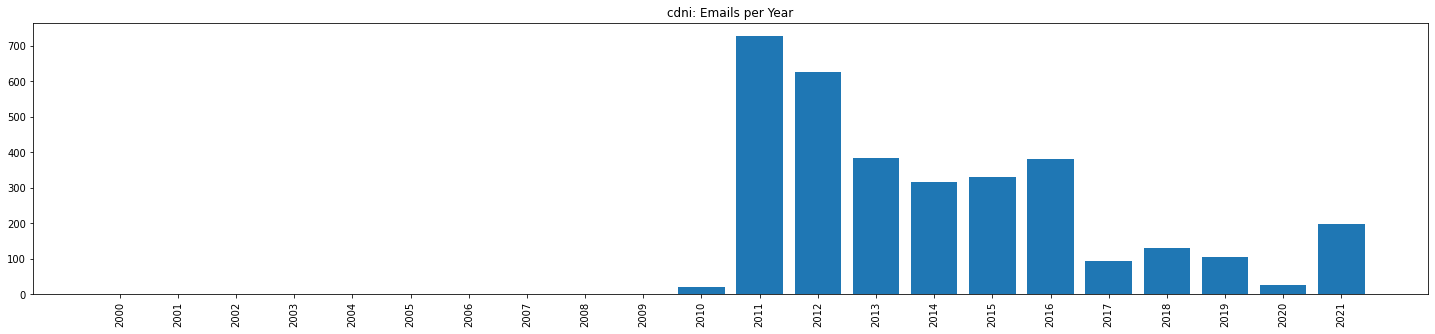

 25%|██▌       | 1/4 [00:02<00:06,  2.08s/it]

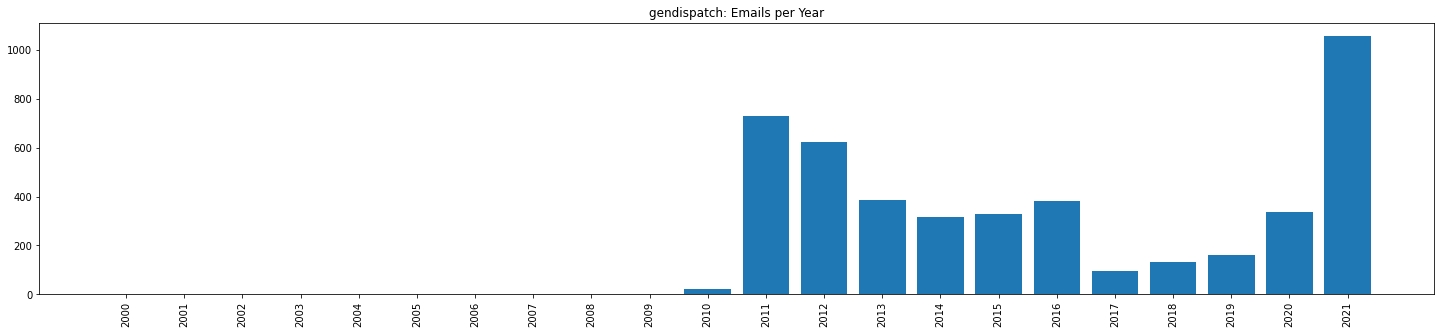

 50%|█████     | 2/4 [00:04<00:04,  2.12s/it]

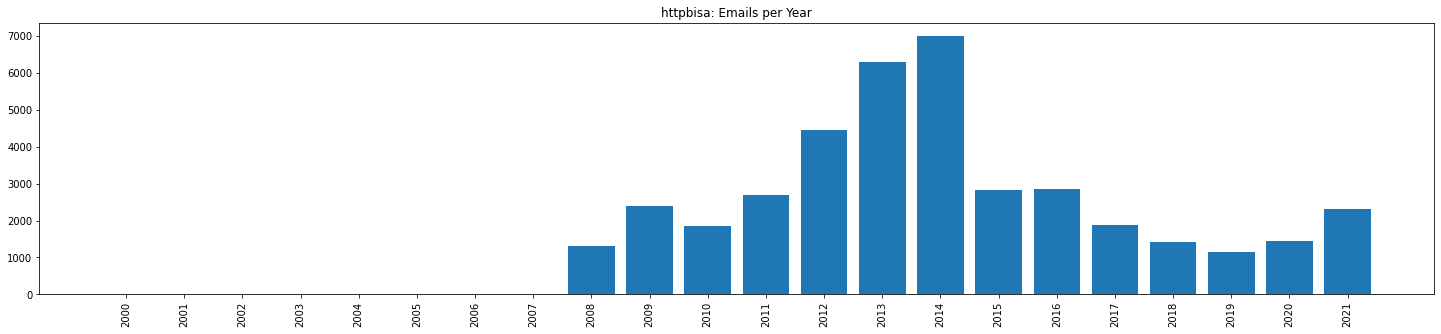

 75%|███████▌  | 3/4 [00:06<00:02,  2.12s/it]

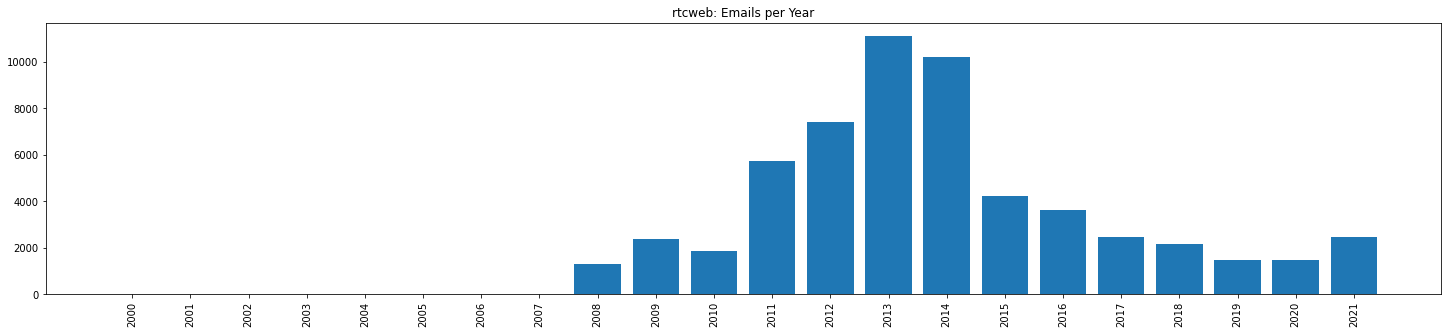

100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


In [27]:
from datetime import datetime

years = ['2010','2011','2012','2013','2014','2015','2016', '2017', '2018', '2019', '2020', '2021']
# months = ["Jan", "Feb", "Mar", "Apr", "May","Jun","Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
count_emails_per_month = {}
for i in range(2000,2022):
#     for y in years:
# #         count_emails_per_month[str(i) + " " + y] = 0
         count_emails_per_month[str(i)] = 0
     
for grp in tqdm(list(df["list"].unique())):
    for index, row in df.iterrows():
        if row["list"] == grp:
#             s = row['headers.Date'].split()[3] +  " " + row['headers.Date'].split()[2]
            s = row['headers.Date'].split()[3]
#             print(s)
#             except:
#                 print(row)
#                 break
            if s in count_emails_per_month.keys():
                count_emails_per_month[s] += 1
            else:
                count_emails_per_month[s] = 1
#     break    
#     print(count_emails_per_month)
    fig, ax = plt.subplots(figsize=(25,5))
    ax.set_title(grp + ": Emails per Year")
    ax.bar(range(len(count_emails_per_month)), list(count_emails_per_month.values()), align='center')
    ax.set_xticks(np.arange(len(count_emails_per_month)))
    ax.set_xticklabels(list(count_emails_per_month.keys()), rotation="vertical",
                      fontdict={'fontsize': 10})
    # plt.setp( ax.xaxis.get_minorticklabels(), rotation=70 )
    plt.show()

# Creation of network

In [28]:
connection = dict()
for i in tqdm(range(len(df))):
    mid = df.iloc[i]["headers.Message-ID"]
    replies = df[df["headers.In-Reply-To"] == mid]
    if df.iloc[i]['name'] in connection.keys():
        connection[df.iloc[i]['name']] = connection[df.iloc[i]['name']].union(set([ replies.iloc[j]['name'] for j in range(len(replies))]))
    else:
        connection[df.iloc[i]['name']] = set([ replies.iloc[j]['name'] for j in range(len(replies)) ])

100%|██████████| 57966/57966 [02:30<00:00, 384.44it/s]


In [29]:
# connection


In [30]:
network = nx.Graph()
for k,v in connection.items():
    for u in list(v):
        network.add_edge(k,u)

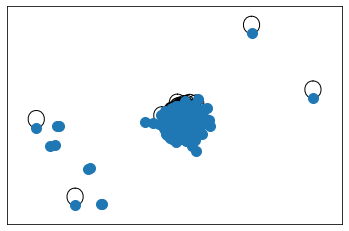

In [31]:
##### # nx.draw_networkx(network, with_labels=False, node_size=1500, node_color="skyblue")
# plt.title("random_layout")
# plt.show()
 

nx.random_layout(network)
nx.draw_networkx(network, with_labels=False, node_size=100)


In [32]:
sub_graph = (network.subgraph(c) for c in nx.connected_components(network))
sub_graph = list(sub_graph)


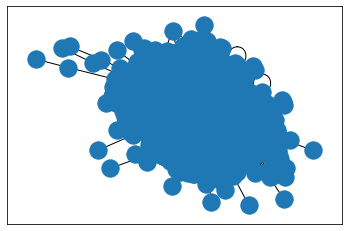

In [33]:
sub_graph
nx.draw_networkx(sub_graph[0], with_labels=False)

# Network connectivity

Now the network is made, we can now explore more about a particular node in the network.

1) Degree -
Degree of a node defines the number of connections a node has. NetworkX has the function degree which we can use to determine the degree of a node in the network.

2) Clustering Coefficient -
It is observed that people who share connections in a social network tend to form associations. In other words, there is a tendency in a social network to form clusters. We can determine the clusters of a node, Local Clustering Coefficient, which is the fraction of pairs of the node's friends that are connected with each other using nx.clustering(Graph, Node) function.



In [34]:
"""
Degree of a node defines the number of connections a node has
"""
degree = nx.degree(network)
#degree

In [35]:

degree_values = sorted([v for k, v in degree], reverse=True)
#degree_values


In [36]:
max(degree_values)

429

In [37]:
"""
clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together
"""
clustering_coefficient = nx.clustering(network)
#clustering_coefficient



In [38]:
# """
# Find the distance of a node from every other node in the network using breadth-first search algorithm
# """
# T =nx.bfs_tree(network, "doug")


In [39]:
# # nx.random_layout(T)
# pos=nx.fruchterman_reingold_layout(T)
# nx.draw_networkx(T, pos=pos, with_labels=False)

# Network Influencers

In this section, we will learn how to find the most important nodes (individuals) in the network. Parameters called centrality measures
helps us in identifying popularity, most liked, and biggest influencers within the network.

1) Degree Centrality - 
Degree centrality is a measure of the number of connections a particular node has in the network. It is based on the fact that important nodes have many connections. NetworkX has the function degree_centrality() to calculate the degree centrality of all the nodes of a network.

2) Eigenvector Centrality -
It is not just how many individuals one is connected to, but the type of people one is connected with that can decide the importance of a node.
It decides that a node is important if it is connected to other important nodes. We can use the eigenvector_centrality() function of NetworkX to calculate eigenvector centrality of all the nodes in a network.

3) Betweenness Centrality -
The Betweenness Centrality is the centrality of control. It represents the frequency at which a point occurs on the shortest paths that connected pair of points. It quantifies how many times a particular node comes in the shortest chosen path between two other nodes.
Networkx has the function betweenness_centrality() to measure it for the network.




In [40]:
deg_cent = nx.degree_centrality(network)
#deg_cent

In [41]:
eig_cent = nx.eigenvector_centrality(network)
#eig_cent

In [42]:
betwn_cent = nx.betweenness_centrality(network)
#betwn_cent

Below graph is to visualize the network such that the node color varies with Degree and node size with Betweenness Centrality. 

In [43]:
"""
We can also visualize the network such that the node color varies with Degree and node size with Betweenness Centrality. 
"""
# pos=nx.random_layout(network)
# betCent = nx.betweenness_centrality(network, normalized=True, endpoints=True)
# node_color = [20000.0 * network.degree(v) for v in network]
# node_size =  [v * 10000 for v in betCent.values()]
# plt.figure(figsize=(25,25))
# nx.draw_networkx(network, pos=pos, with_labels=False,
#                  node_color=node_color,
#                  node_size=node_size )
# plt.axis('off')

'\nWe can also visualize the network such that the node color varies with Degree and node size with Betweenness Centrality. \n'

In [44]:
sorted(deg_cent, key=deg_cent.get, reverse=True)[:5]


['mnot', 'martin.thomson', 'julian.reschke', 'w', 'harald']

In [45]:
 sorted(eig_cent, key=eig_cent.get, reverse=True)[:5]

['martin.thomson', 'mnot', 'julian.reschke', 'ekr', 'internet-drafts']

In [46]:
sorted(betwn_cent, key=betwn_cent.get, reverse=True)[:5]

['mnot', 'julian.reschke', 'martin.thomson', 'internet-drafts', 'w']

In [47]:
data = [['touch', 'michael.scharf', 'internet-drafts', 'mallman', 'ycheng'], ['touch', 'michael.scharf', 'internet-drafts', 'ycheng', 'mallman'], ['touch', 'internet-drafts', 'michael.scharf', 'cyrus', 'mallman']]

In [48]:
# data.transpose()
df_new = pd.DataFrame(data)
df_new = df_new.transpose()
df_new.columns=["Degree_cent", "Eig_cent", "Between_cent"]
df_new
# df_new = pd.DataFrame(data_transposed, columns=["Degree_cent", "Eig_cent", "Between_cent"])


,Degree_cent,Eig_cent,Between_cent
0,touch,touch,touch
1,michael.scharf,michael.scharf,internet-drafts
2,internet-drafts,internet-drafts,michael.scharf
3,mallman,ycheng,cyrus
4,ycheng,mallman,mallman


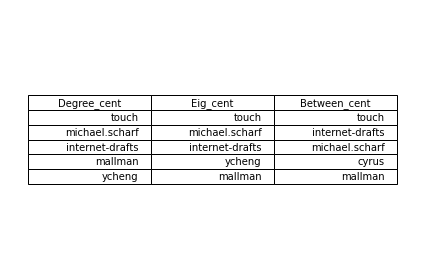

In [49]:
fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
t= ax.table(cellText=df_new.values, colWidths = [0.3]*len(df_new.columns), colLabels=df_new.columns, loc='center')
t.auto_set_font_size(False) 
t.set_fontsize(10)
fig.tight_layout()
plt.show()

# Topic modelling

In [50]:
"""
Convert sentence to words
"""
def sent_to_words(sentences):
    for sent in sentences:
        try:
            sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
            sent = re.sub('\s+', ' ', sent)  # remove newline chars
            sent = re.sub("\'", "", sent)  # remove single quotes
            sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        except:
            print(sent)
            continue
        yield(sent)  

# Convert to list
data = df["headers.Subject"].values.tolist()
data_words = list(sent_to_words(data))


In [51]:
stopwords_list.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stopwords_list=stopwords_list, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stopwords_list] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stopwords_list] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [52]:
for i,x in enumerate(data_ready):
    if len(x) == 0:
        print(i,data_words[i])
        
'tcp' in stopwords_list

4826 ['re']
4829 ['re']
4833 ['re']
4836 ['re']
4838 ['re']
4857 ['re']
4859 ['re']
4860 ['re']
4890 ['re']
5083 ['re']
5087 ['re']
5088 ['re']
5089 ['re']
5090 ['re']
5091 ['re']
5095 ['re']
5107 ['re']
5130 ['re']
5131 ['re']
5132 ['re']
5136 ['re']
5138 ['re']
5142 ['re']
5143 ['re']
5145 ['re']
5146 ['re']
5147 ['re']
5149 ['re']
5150 ['re']
7533 ['http']
7535 ['re', 'http']
7536 ['re', 'http']
7537 ['re', 'http']
7538 ['re', 'http']
7539 ['re', 'http']
7540 ['re', 'http']
7542 ['re', 'http']
7543 ['re', 'http']
7544 ['re', 'http']
7545 ['re', 'http']
7546 ['re', 'http']
7547 ['re', 'http']
7548 ['re', 'http']
7549 ['re', 'http']
7552 ['re', 'http']
7553 ['re', 'http']
7606 ['re', 'http']
7608 ['re', 'http']
7974 ['re', 'http']
11367 ['the', 'use', 'of', 'http']
11368 ['re', 'the', 'use', 'of', 'http']
12472 ['cr', 'cr', 'lf']
12474 ['re', 'cr', 'cr', 'lf']
12680 ['re', 'cr', 'cr', 'lf']
13984 ['may', 'should']
14019 ['use', 'of', 'may', 'and', 'should']
14021 ['re', 'use', 'of', '

False

In [53]:
id2word = Dictionary(data_ready)
len(id2word)

corpus = [id2word.doc2bow(d) for d in data_ready]


In [54]:
corpus[:1]

[[(0, 2),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1)]]

In [55]:
id2word[3]

'delivery'

In [56]:
models = []
perplexities = []
coherences = []
# topics = [20, 100, 200]

lda_model = LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       num_topics=20, 
                       random_state=100,
                       chunksize=100,
                       passes=5,
                       alpha='symmetric',
                       iterations=100,
                       per_word_topics=True,
                       workers=5)
models.append(lda_model)
perplexities.append(lda_model.log_perplexity(corpus))
coherence_model = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherences.append(coherence_model.get_coherence())

In [57]:
topics =[20,100,200]

In [58]:
print(lda_model.print_topics())
# doc_lda = lda_model[corpus]

[(0, '0.371*"group" + 0.166*"working" + 0.132*"meeting" + 0.114*"ietf" + 0.092*"draft" + 0.037*"adopt" + 0.033*"last" + 0.004*"july" + 0.003*"quebec" + 0.002*"city"'), (1, '0.289*"discuss" + 0.209*"datum" + 0.085*"list" + 0.085*"name" + 0.074*"trust" + 0.066*"design" + 0.046*"submit" + 0.024*"model" + 0.017*"mailing" + 0.013*"creation"'), (2, '0.281*"digest" + 0.170*"early" + 0.148*"push" + 0.107*"continuation" + 0.064*"problem" + 0.061*"relate" + 0.046*"charter" + 0.022*"date" + 0.014*"june" + 0.013*"pull"'), (3, '0.473*"cdni" + 0.302*"case" + 0.065*"next" + 0.049*"requirement" + 0.017*"step" + 0.008*"scenario" + 0.004*"replace" + 0.003*"incorporate" + 0.002*"draft" + 0.002*"publisher"'), (4, '0.236*"consensus" + 0.160*"requirement" + 0.110*"forward" + 0.104*"cdn" + 0.066*"sign" + 0.063*"loop" + 0.042*"extend" + 0.036*"side" + 0.035*"language" + 0.034*"level"'), (5, '0.736*"request" + 0.113*"limit" + 0.036*"definition" + 0.019*"available" + 0.010*"route" + 0.007*"week" + 0.002*"agree"

In [59]:
print(topics[0], perplexities[0], coherences[0])

20 -23.005634986181033 0.4988451754816329


In [60]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in tqdm(enumerate(ldamodel[corpus])):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#                 print(topic_num,topic_keywords)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(20)

57966it [01:45, 550.92it/s]


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.4224,"non, redirection, information, delivery, netwo...","[cdni, new, non, mailing, list, cdni, intercon..."
1,1,1.0,0.4722,"discuss, datum, list, name, trust, design, sub...","[cdni, cdn, interconnect, bof, prague, request..."
2,2,13.0,0.2100,"comment, draft, ietf, semantic, editorial, log...","[cdni, comment, problem, statement]"
3,3,13.0,0.2100,"comment, draft, ietf, semantic, editorial, log...","[cdni, comment, problem, statement]"
4,4,13.0,0.2100,"comment, draft, ietf, semantic, editorial, log...","[cdni, comment, problem, statement]"
5,5,1.0,0.4722,"discuss, datum, list, name, trust, design, sub...","[cdni, cdn, interconnect, bof, prague, request..."
6,6,13.0,0.2100,"comment, draft, ietf, semantic, editorial, log...","[cdni, comment, problem, statement]"
7,7,19.0,0.3418,"call, last, control, work, extension, policy, ...","[cdni, cdn, interconnect, prior, work]"
8,8,13.0,0.2100,"comment, draft, ietf, semantic, editorial, log...","[cdni, comment, problem, statement]"
9,9,13.0,0.2100,"comment, draft, ietf, semantic, editorial, log...","[cdni, comment, problem, statement]"


In [61]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.4224,"non, redirection, information, delivery, netwo...","[cdni, new, non, mailing, list, cdni, intercon..."
1,1,1.0,0.4722,"discuss, datum, list, name, trust, design, sub...","[cdni, cdn, interconnect, bof, prague, request..."
2,2,13.0,0.2100,"comment, draft, ietf, semantic, editorial, log...","[cdni, comment, problem, statement]"
3,3,13.0,0.2100,"comment, draft, ietf, semantic, editorial, log...","[cdni, comment, problem, statement]"
4,4,13.0,0.2100,"comment, draft, ietf, semantic, editorial, log...","[cdni, comment, problem, statement]"
5,5,1.0,0.4722,"discuss, datum, list, name, trust, design, sub...","[cdni, cdn, interconnect, bof, prague, request..."
6,6,13.0,0.2100,"comment, draft, ietf, semantic, editorial, log...","[cdni, comment, problem, statement]"
7,7,19.0,0.3418,"call, last, control, work, extension, policy, ...","[cdni, cdn, interconnect, prior, work]"
8,8,13.0,0.2100,"comment, draft, ietf, semantic, editorial, log...","[cdni, comment, problem, statement]"
9,9,13.0,0.2100,"comment, draft, ietf, semantic, editorial, log...","[cdni, comment, problem, statement]"


In [62]:
df_dominant_topic["Dominant_Topic"].value_counts()

0.0     15326
18.0     5146
16.0     4994
19.0     3595
8.0      3412
11.0     2859
13.0     2517
15.0     2096
3.0      1952
12.0     1920
7.0      1834
17.0     1735
2.0      1681
4.0      1679
5.0      1499
1.0      1497
6.0      1483
14.0     1455
9.0       792
10.0      494
Name: Dominant_Topic, dtype: int64

In [62]:
df_dominant_topic["Dominant_Topic"].value_counts()

0.0     15326
18.0     5146
16.0     4994
19.0     3595
8.0      3412
11.0     2859
13.0     2517
15.0     2096
3.0      1952
12.0     1920
7.0      1834
17.0     1735
2.0      1681
4.0      1679
5.0      1499
1.0      1497
6.0      1483
14.0     1455
9.0       792
10.0      494
Name: Dominant_Topic, dtype: int64

In [62]:
df_dominant_topic["Dominant_Topic"].value_counts()

0.0     15326
18.0     5146
16.0     4994
19.0     3595
8.0      3412
11.0     2859
13.0     2517
15.0     2096
3.0      1952
12.0     1920
7.0      1834
17.0     1735
2.0      1681
4.0      1679
5.0      1499
1.0      1497
6.0      1483
14.0     1455
9.0       792
10.0      494
Name: Dominant_Topic, dtype: int64

In [62]:
df_dominant_topic["Dominant_Topic"].value_counts()

0.0     15326
18.0     5146
16.0     4994
19.0     3595
8.0      3412
11.0     2859
13.0     2517
15.0     2096
3.0      1952
12.0     1920
7.0      1834
17.0     1735
2.0      1681
4.0      1679
5.0      1499
1.0      1497
6.0      1483
14.0     1455
9.0       792
10.0      494
Name: Dominant_Topic, dtype: int64

In [63]:
for i in range(10):
    print(df_dominant_topic[df_dominant_topic["Dominant_Topic"] == i].iloc[0]["Keywords"])

group, working, meeting, ietf, draft, adopt, last, july, quebec, city
discuss, datum, list, name, trust, design, submit, model, mailing, creation
digest, early, push, continuation, problem, relate, charter, date, june, pull
cdni, case, next, requirement, step, scenario, replace, incorporate, draft, publisher
consensus, requirement, forward, cdn, sign, loop, extend, side, language, level
request, limit, definition, available, route, week, agree, iterative, cdni, header
review, draft, ietf, progress, interface, metadata, extensibility, informal, trigger, note
question, session, redirect, additional, schedule, framework, delegation, advanced, rtcweb, client
issue, proposal, specification, interim, reference, regard, final, base, app, system
non, redirection, information, delivery, network, routing, wg, tie, slot, interconnection


In [64]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.365160  0.000919       1        1  10.185305
11    -0.229726  0.038789       2        1   7.376374
18     0.112093  0.314221       3        1   7.269212
19     0.058312  0.210936       4        1   6.701618
13    -0.317367 -0.021276       5        1   5.931931
8      0.122423  0.045303       6        1   5.487750
3      0.120872 -0.144817       7        1   5.114808
15     0.117676  0.139844       8        1   4.953650
12    -0.285577 -0.033143       9        1   4.852298
1      0.124057  0.026908      10        1   4.828029
6     -0.304205 -0.040184      11        1   4.643390
17     0.125380 -0.023157      12        1   4.357074
4      0.131841 -0.094464      13        1   4.326268
2      0.121355  0.068726      14        1   3.899621
14     0.127377 -0.065846      15        1   3.791001
7      0.130203 -0.076930      16        1   3.778428
5      0.130021 -0.074215      17        1   3.609689
0     -0.194096  0.006621      18        1   3.431637
9      0.137944 -0.143996      19        1   2.912626
10     0.136577 -0.134241      20        1   2.549291, topic_info=          Term          Freq         Total Category  logprob  loglift
245       http  18725.000000  18725.000000  Default  30.0000  30.0000
26       draft  36749.000000  36749.000000  Default  29.0000  29.0000
15     request   8367.000000   8367.000000  Default  28.0000  28.0000
57        ietf  19416.000000  19416.000000  Default  27.0000  27.0000
148       call   9653.000000   9653.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
956  different      0.312141      3.581403  Topic20 -10.1546   1.2293
801   practice      0.312141      3.581444  Topic20 -10.1546   1.2293
898   property      0.312031      3.581285  Topic20 -10.1550   1.2290
576     medium      0.312159      3.583048  Topic20 -10.1545   1.2289
0         cdni      0.315569   7648.457494  Topic20 -10.1437  -6.4263

[781 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
74        3  0.477463  acquisition
39        1  0.999279       action
210       8  0.974897     adaptive
210      15  0.010954     adaptive
295      16  0.996125   additional
...     ...       ...          ...
60        4  0.620135        white
20        4  0.998674         work
144      18  0.998166      working
113       8  0.846783           答复
134       4  0.614974           转发

[279 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 12, 19, 20, 14, 9, 4, 16, 13, 2, 7, 18, 5, 3, 15, 8, 6, 1, 10, 11])